In [6]:
import numpy as np
import torch
import pyro
import matplotlib.pyplot as plt

from pyro.distributions import Categorical
from pyro.distributions import Categorical
from pyro.infer import Importance, EmpiricalMarginal

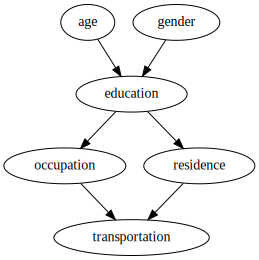

In [7]:
A_alias = ['young', 'adult', 'old']
S_alias = ['M', 'F']
E_alias = ['high', 'uni']
O_alias = ['emp', 'self']
R_alias = ['small', 'big']
T_alias = ['car', 'train', 'other']

A_prob = torch.tensor([0.3,0.5,0.2])
S_prob = torch.tensor([0.6,0.4])
E_prob = torch.tensor([[[0.75,0.25], [0.72,0.28], [0.88,0.12]], # 3X2
                       [[0.64,0.36], [0.7,0.3], [0.9,0.1]]])
O_prob = torch.tensor([[0.96,0.04], [0.92,0.08]])
R_prob = torch.tensor([[0.25,0.75], [0.2,0.8]])
T_prob = torch.tensor([[[0.48,0.42,0.1], [0.56,0.36,0.08]],
                       [[0.58,0.24,0.18], [0.7,0.21,0.09]]])

def model():
    A = pyro.sample("age", Categorical(probs=A_prob)) 
    S = pyro.sample("gender", Categorical(probs=S_prob)) 
    E = pyro.sample("education", Categorical(probs=E_prob[S][A])) 
    O = pyro.sample("occupation", Categorical(probs=O_prob[E]))
    R = pyro.sample("residence", Categorical(probs=R_prob[E]))
    T = pyro.sample("transportation", Categorical(probs=T_prob[R][O])) 
    return{'A': A,'S': S,'E': E,'O': O,'R': R,'T': T} 

pyro.render_model(model)

### Importance sampling
(No yet causal inference)

In [10]:
conditioned_model = pyro.condition(model,
                                   data={'T':torch.tensor(1)} # T=Evidence ?
                                   )

m = 5000
posterior = pyro.infer.Importance(conditioned_model,    
                                  num_samples=m    
                                  ).run()

E_marginal = EmpiricalMarginal(posterior, "education")    
E_samples = [E_marginal().item() for _ in range(m)]    
E_unique, E_counts = np.unique(E_samples, return_counts=True)    
E_probs = E_counts / m

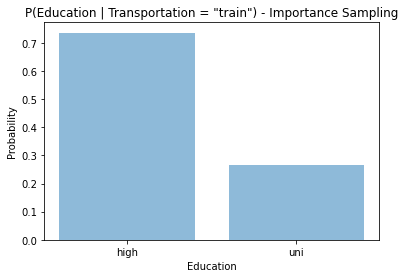

In [12]:
plt.bar(E_unique, E_probs, align='center', alpha=0.5)    
plt.xticks(E_unique, E_alias)    
plt.ylabel('Probability')    
plt.xlabel('Education')   
plt.title('P(Education | Transportation = "train") - Importance Sampling') 
plt.show()